### Домашнее задание 5

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [7]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [8]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [9]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [11]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [12]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [13]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

##### Здесь добавлен StandardScaler

In [25]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler(cont_col)) # добавлен scaler
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [16]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [17]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [18]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [19]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [20]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
models_results = {
    'Model Name': [],
    'F-score': [],
    'Precision': [],
    'Recall': []
}

def res_update(res_dict, name, fscore, prec, rec):
    upd_list = [name, fscore, prec, rec]
    for upd in enumerate(upd_list):
        res_dict[list(models_results.keys())[upd[0]]].append(upd[1])
    return res_dict


res_update(models_results, 'RandomForest',
                           fscore[ix],
                           precision[ix],
                           recall[ix])

models_results

{'Model Name': ['RandomForest'],
 'F-score': [0.6412825651302605],
 'Precision': [0.65439672801636],
 'Recall': [0.6286836935166994]}

##### Logistic Regression

In [40]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [43]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


In [46]:
res_update(models_results, 'LogisticRegression',
                           fscore[ix],
                           precision[ix],
                           recall[ix])

models_results

{'Model Name': ['RandomForest', 'LogisticRegression'],
 'F-score': [0.6412825651302605, 0.5097001763668431],
 'Precision': [0.65439672801636, 0.4624],
 'Recall': [0.6286836935166994, 0.5677799607072691]}

##### Gradient Boosting

In [48]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [50]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [51]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


In [53]:
res_update(models_results, 'GradientBoosting',
                           fscore[ix],
                           precision[ix],
                           recall[ix])

models_results

{'Model Name': ['RandomForest', 'LogisticRegression', 'GradientBoosting'],
 'F-score': [0.6412825651302605, 0.5097001763668431, 0.6461211477151967],
 'Precision': [0.65439672801636, 0.4624, 0.7037037037037037],
 'Recall': [0.6286836935166994, 0.5677799607072691, 0.5972495088408645]}

##### XGBoost

In [54]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42)),
])

In [56]:
pipeline.fit(X_train, y_train)

[17:09:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [57]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.47611395, 0.23087966, 0.07372608, 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633


In [60]:
res_update(models_results, 'XGB',
                           fscore[ix],
                           precision[ix],
                           recall[ix])

models_results

{'Model Name': ['RandomForest',
  'LogisticRegression',
  'GradientBoosting',
  'XGB'],
 'F-score': [0.6412825651302605,
  0.5097001763668431,
  0.6461211477151967,
  0.6258503401360545],
 'Precision': [0.65439672801636,
  0.4624,
  0.7037037037037037,
  0.6192307692307693],
 'Recall': [0.6286836935166994,
  0.5677799607072691,
  0.5972495088408645,
  0.6326129666011788]}

In [61]:
models_results = pd.DataFrame(models_results)
models_results

,Model Name,F-score,Precision,Recall
0,RandomForest,0.641283,0.654397,0.628684
1,LogisticRegression,0.509700,0.462400,0.567780
2,GradientBoosting,0.646121,0.703704,0.597250
3,XGB,0.625850,0.619231,0.632613


In [68]:
models_results.sort_values(by='F-score', ascending=False)

,Model Name,F-score,Precision,Recall
2,GradientBoosting,0.646121,0.703704,0.597250
0,RandomForest,0.641283,0.654397,0.628684
3,XGB,0.625850,0.619231,0.632613
1,LogisticRegression,0.509700,0.462400,0.567780


Recall показывает процент верно предсказанных "ушедших" клиентов
Precision показывает как часто модель улавливает случаи "уходящих" клиентов.
Поэтому для полноты картины работы модели будем использовать Fscore.

Делаем выбор в пользу GradientBoosting

In [69]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [70]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [71]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [72]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


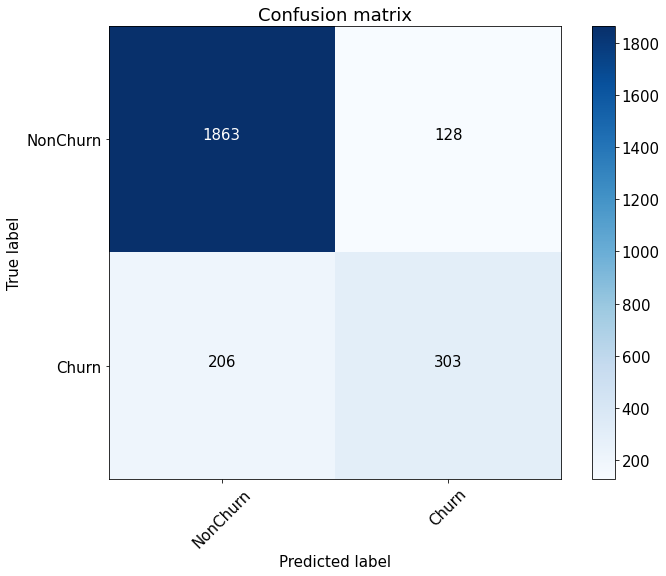

In [73]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного

In [79]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [81]:
(TP * 2) - (FP + TP)

175

Прибыль составляет 175 долларов. 2 доллара за правильно классифицированных минус затраты на привлечение правильно и не правильно классифицированных.

##### Подбор параметров для GradientBoosting

In [124]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7, 0.9],
        'classifier__min_samples_leaf':[1, 2, 3, 4, 5],
        'classifier__max_depth': [2, 4, 6, 8]
        }

Запускаем перебор

In [125]:
%%time
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

CPU times: user 5min 42s, sys: 15.7 ms, total: 5min 42s
Wall time: 5min 42s


{'classifier__max_depth': 4,
 'classifier__max_features': 0.7,
 'classifier__min_samples_leaf': 5}

Обучаем модель уже сновыми параметрами

In [126]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth=4, max_features=0.7, 
                                          min_samples_leaf=5, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.417058, F-Score=0.639, Precision=0.684, Recall=0.599
Confusion matrix, without normalization
[[1850  141]
 [ 205  304]]


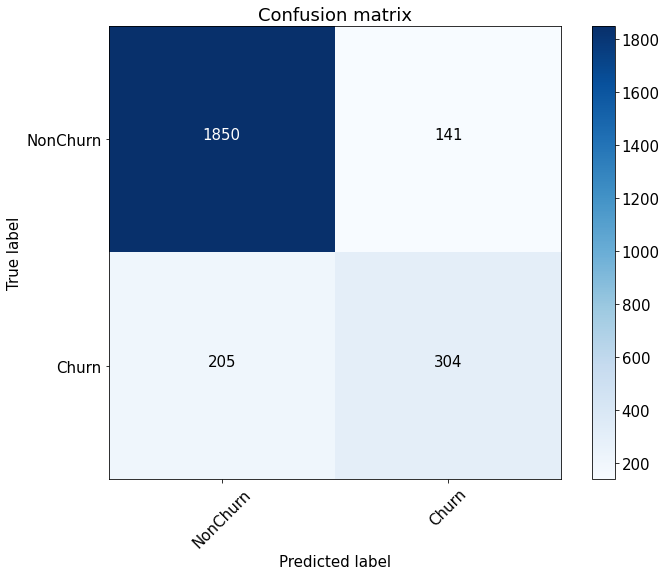

In [127]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [129]:
models_results = models_results.append({'Model Name': 'GB_tuned',
                                        'F-score': fscore[ix],
                                        'Precision': precision[ix],
                                        'Recall': recall[ix]}, 
                                         ignore_index=True)

models_results.sort_values(by='F-score', ascending=False)

,Model Name,F-score,Precision,Recall
2,GradientBoosting,0.646121,0.703704,0.597250
0,RandomForest,0.641283,0.654397,0.628684
4,GB_tuned,0.638743,0.683857,0.599214
3,XGB,0.625850,0.619231,0.632613
1,LogisticRegression,0.509700,0.462400,0.567780


In [130]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [131]:
(TP * 2) - (FP + TP)

163

Очень странный результат получаю. хуже, чем без параметров.